In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
current_path = os.getcwd()

races_path = current_path+"\Data\images\Images\\"

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  races_path,
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3629 files belonging to 20 classes.
Using 2904 files for training.


In [5]:
val_ds  = tf.keras.preprocessing.image_dataset_from_directory(
  races_path,
  labels="inferred",
  label_mode="int",
  class_names=None,
  color_mode="rgb",
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3629 files belonging to 20 classes.
Using 725 files for validation.


In [6]:
class_names = train_ds.class_names
print(len(class_names))

20


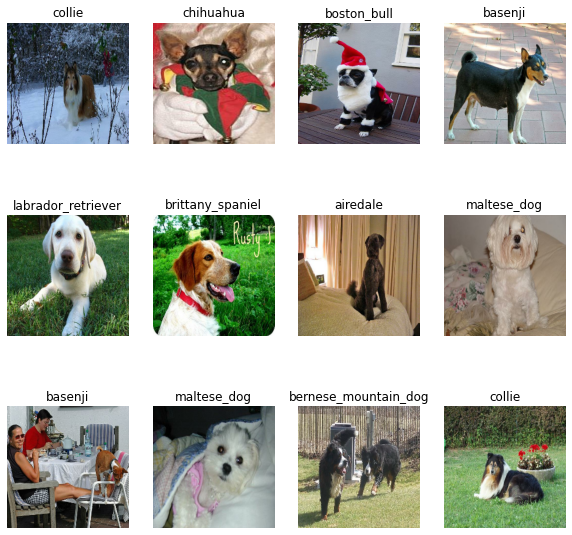

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

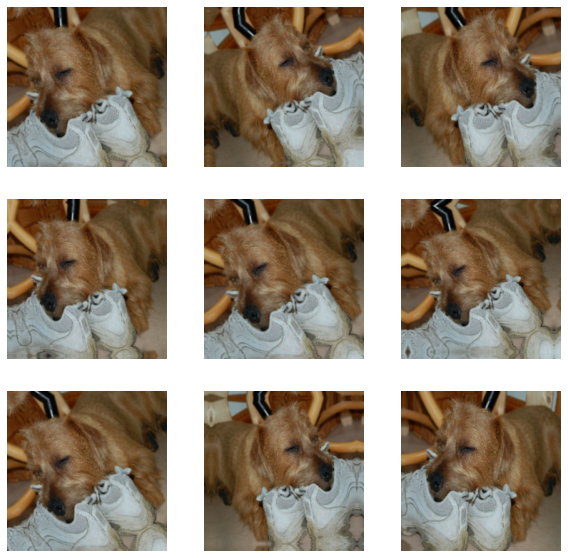

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
num_classes = 20

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
91/91 [==============================] - 42s 452ms/step - loss: 3.2825 - accuracy: 0.0563 - val_loss: 2.9133 - val_accuracy: 0.1172
Epoch 2/10
91/91 [==============================] - 39s 428ms/step - loss: 2.8313 - accuracy: 0.1250 - val_loss: 2.6429 - val_accuracy: 0.1779
Epoch 3/10
91/91 [==============================] - 39s 430ms/step - loss: 2.6194 - accuracy: 0.1705 - val_loss: 2.5425 - val_accuracy: 0.2041
Epoch 4/10
91/91 [==============================] - 39s 431ms/step - loss: 2.5332 - accuracy: 0.2067 - val_loss: 2.5889 - val_accuracy: 0.1931
Epoch 5/10
91/91 [==============================] - 40s 436ms/step - loss: 2.4620 - accuracy: 0.2391 - val_loss: 2.4093 - val_accuracy: 0.2648
Epoch 6/10
91/91 [==============================] - 39s 432ms/step - loss: 2.3590 - accuracy: 0.2560 - val_loss: 2.3783 - val_accuracy: 0.2648
Epoch 7/10
91/91 [==============================] - 39s 431ms/step - loss: 2.2866 - accuracy: 0.3003 - val_loss: 2.2824 - val_accuracy: 0.3007

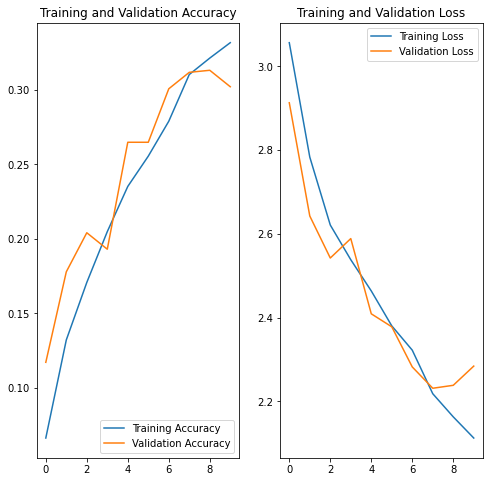

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
predictions  = model.predict(val_ds)

In [18]:
score = tf.nn.softmax(predictions[0])


In [30]:
y_pred = model.predict(val_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)
print(true_categories)

tf.Tensor(
[ 6 12  3 14  5  4 13  5 13 17  9  0 18 15  6  3  8 15  6  3 16  2  4 10
  2 19  1  6  3 15 17 17  3  1 15 15 19  1 15 16  9  1  1 14  0 19  7 19
 15  0 15 15  2 18 15 15 15 16 10  1  8  3  5 16 11  6  4  4  0 13 12  4
  8 19 11 16  1 11 17  8 15 16 10 14 12  9  3 17  4 14  0 11  8 13 17 17
  5 10  5  1  4 11 15 12 19  8  3 12 14 14  0  2 15  3 14 11  2 11  1  3
 18  0 19  6  8 15  8 19 16 17  8  3  7  7  3  4  7 14  5  5  1 12 16  8
  0  4  2 10  4  0  3 13 18 13  9 12  3 17 18 12  3 17  2 13  5 18 15  3
 13 10  1  8 19 10  0 11 10 14 15  6 15 17 17  1 13  0 19  6  9  4  9  4
  2  4 17  3  8 19  4  5  3 17 14  7 18  7 18  5 13  8 14  6 13  1 13  9
 17  0  5  4  0 16 12 17 15  6  9  8  7 10  8  7  5 10 15 17  9 10 17  1
 15 10  4  7  2 13 17 15  4 17  8  0 11  2  2 18 14 15  9 16 15 11  9 15
  9  5 15 10 11  4  6 18 17  4 12 14 12 15 19 19  2  3  4  6 14  4  6  1
  8 14  4 19 13  6  7 17 15  5  5 14 17  7 17 10  1  2  3  9  2 17  3  8
 18 15  6  8 15  0  8  4  8  6 12 12  9 

In [64]:
from sklearn.metrics import confusion_matrix

confu = confusion_matrix(predicted_categories, true_categories)
print(confu)

[[22  1  0  0  1  3  0  0  1  1  2  1  0  0  4  0  0  0  1  1]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  4  1  0]
 [ 1  0 14  0  0  4  0  3  1  0  0  0  0  1  2  0  0  0  2  1]
 [ 0  5  0 11  4  0  5  0  0  4  3  2  1  3  2  1  4  4  1  0]
 [ 0  0  1  0  3  0  0  1  0  0  0  0  1  4  0  0  0  0  0  0]
 [ 0  1  5  1  2 10  1  3  1  1  2  1  0  1  4  2  1  0  4  2]
 [ 0  1  0  8  7  0 18  0  0  9  1  3  5  2  2  3  1  4  0  2]
 [ 1  0  0  1  0  4  0  6  3  1  0  0  0  2  0  1  0  0  2  1]
 [ 2  3 12  6  6 14  5 17 25  6  4  5  1  4  6  2  0  1  2  5]
 [ 0  0  0  2  3  0  1  0  0  2  0  0  0  1  0  1  0  0  0  0]
 [ 0  3  0  1  0  0  0  0  1  2  5  0  0  0  2  2  1  1  0  3]
 [ 0  1  0  2  0  0  1  1  0  1  2  3  1  2  1  1  0  2  0  0]
 [ 0  0  0  0  1  1  2  0  0  0  0  0  5  0  2  6  1  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 3  0  1  2  2  0  0  0  0  0  2  2  0  1  3  0  1  0  1  1]
 [ 0  1  0  0  3  0  0  1  2  2  4  2  9  1  6 31  1 10

In [62]:
model.evaluate(val_ds)

23/23 [==============================] - 4s 189ms/step - loss: 2.2844 - accuracy: 0.30211s - loss: 2.264


[2.284423589706421, 0.3020689785480499]

In [31]:
print(predicted_categories)

tf.Tensor(
[ 9  6  3  2  2  6 16  5  8  3  3  0  3 19  6 11  5 15 17  3 14  8 19  0
  8 15  5  8  3 16 16 17  3 18 17  5  8  1 15 16  8  1 16 18  0  5  7  5
 15 14 15 12  2 18 15  3  5 13 15  1  8  3  5 16  6  6  8 15  0  6 12  6
  8 10 14 16  1 16 16 15  7  3 11  0  8 15  5 17  0 16  0 16  2  9 11 17
  8 10  0 16  8  8 15 15 15  8  3 15  2 15  0  2 15  8 15 16  8  6 18  3
  5  0 16  6  8 15 10 15 12 16  8  9 11  8  3 15  7 14  8  8  1  3 16 15
  0  4  2 16  6  0  8  8 18  2  0 15 18  1 18 17  6 16  2  4  8 18 15  3
 16 15 10  7 19 10  0 11 14  3 15 12 15 17 17 18  7 18 15  6 15 15 11 17
  5  6 19 14  7  8 12  5  9  1 16  5 18  8 18  2  3  8 18  3 11 16  7  5
  6  0  0  8  0 10 17 17 16  6  6  8  2 14 19 18  2  5 15 15 17  8 15 16
 19 17  9  5  2  4 15  6 18 17  8  0 19  8  2  5  6  6  6 16 15  0  6 11
  6  7 15  3 15 18  3 18 10  5  4 17 12 15 19 19  8  6  4  6  0  6  6  1
  8 18  4  8  8  6  8 17 15  8  2  5 17 18  6 16 10  2  6  3  2 16  8  8
  0 12  6  8 12  7  8 18  8  6 12 15  9 

In [38]:
label = tf.concat([y for x, y in val_ds], axis=0)
label_list=[]
for i in range(20):
    label_list.append(class_names[labels[i]])
    print(class_names[labels[i]])

collie
chihuahua
boston_bull
basenji
labrador_retriever
brittany_spaniel
airedale
maltese_dog
basenji
maltese_dog
bernese_mountain_dog
collie
beagle
border_collie
cairn
pomeranian
clumber
border_collie
clumber
cairn


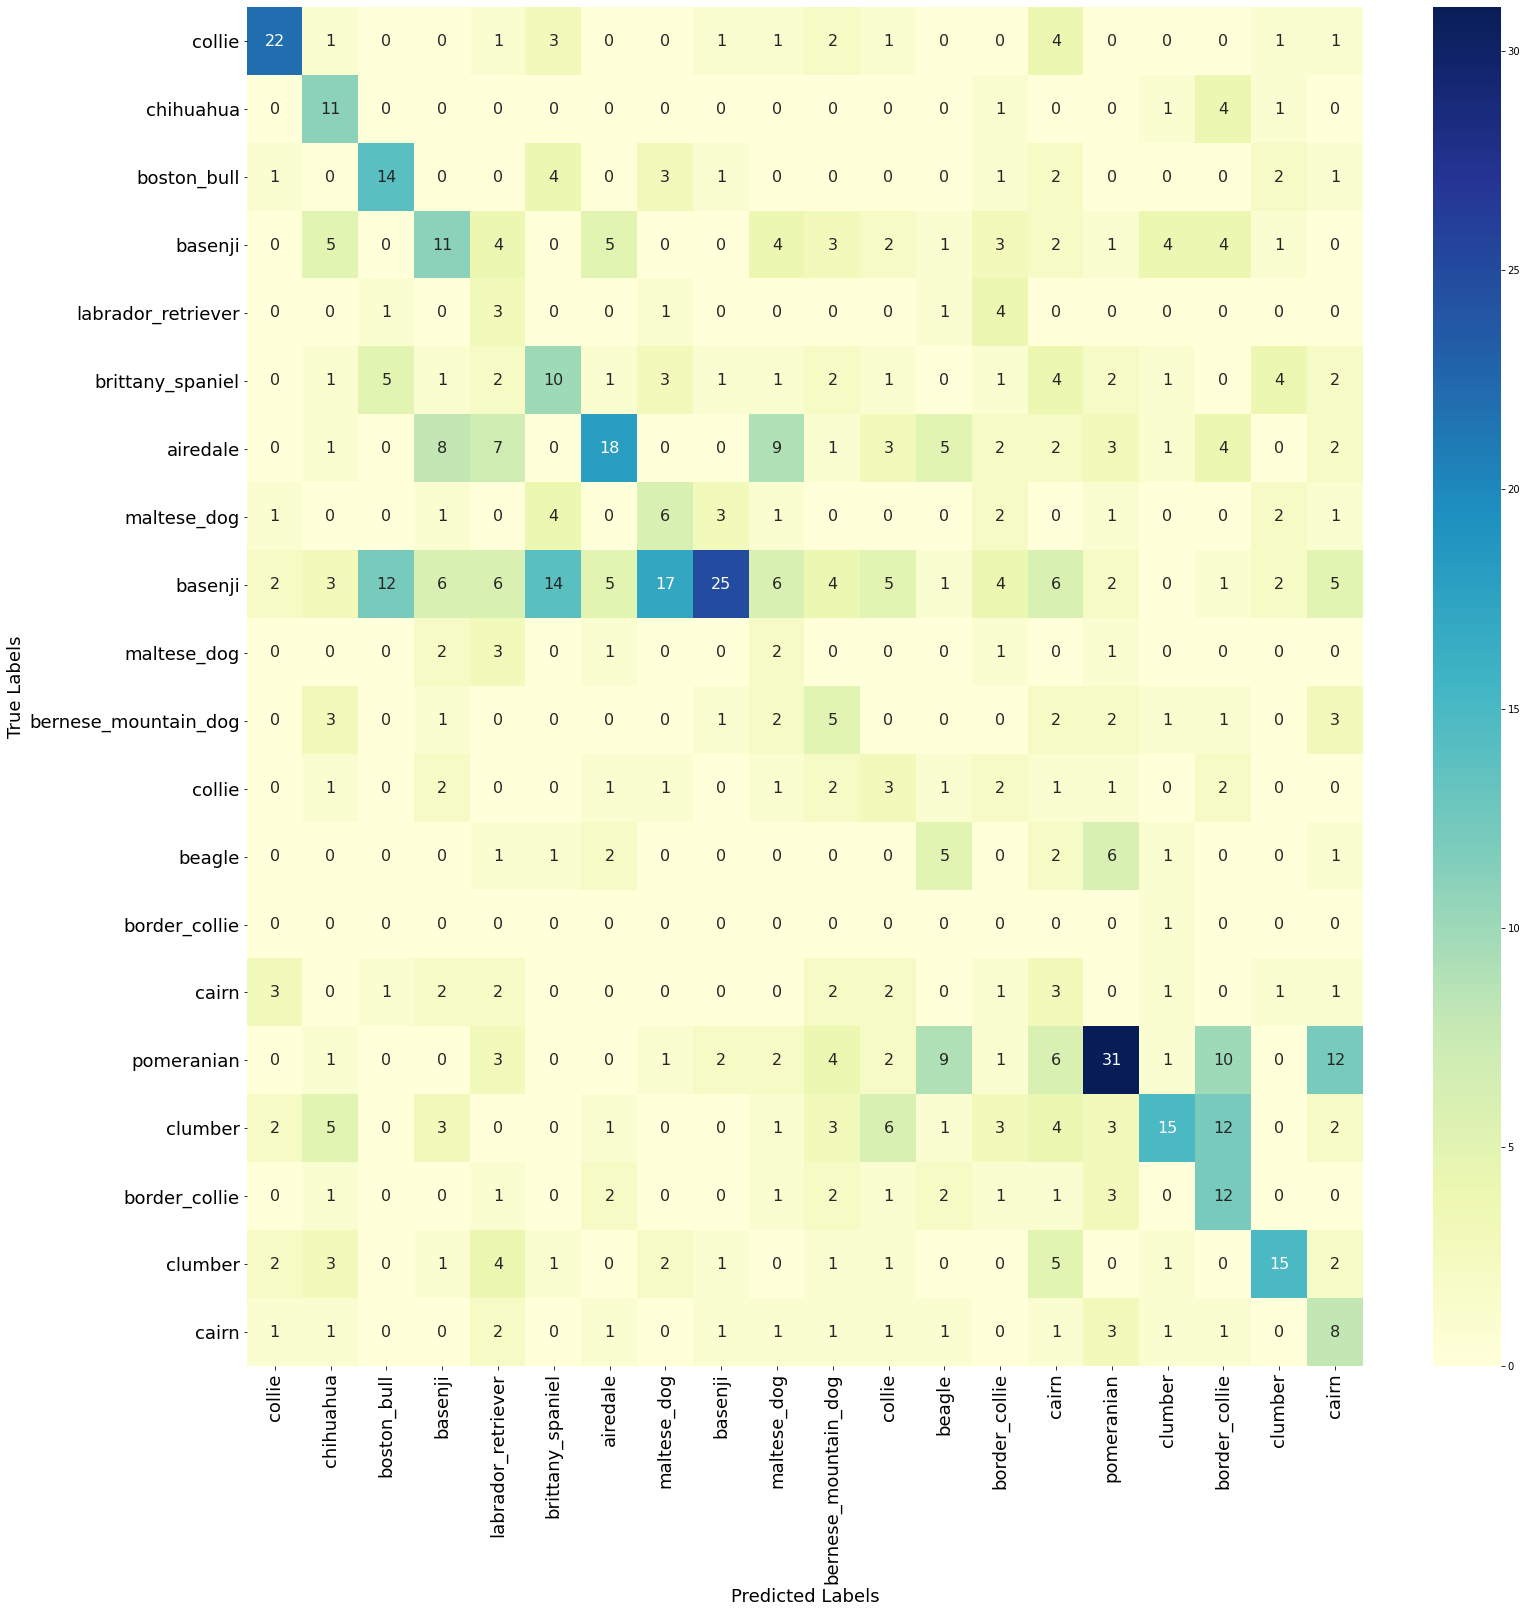

In [61]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confu
df_cm = pd.DataFrame(array, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (25,25))


sn.heatmap(df_cm, annot=True, cmap="YlGnBu",annot_kws={"size": 16})
plt.xlabel("Predicted Labels",fontsize=18)
plt.ylabel("True Labels",fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.show()

In [54]:
>>> print(classification_report(true_categories, predicted_categories, target_names=label_list))


                      precision    recall  f1-score   support

              collie       0.58      0.65      0.61        34
           chihuahua       0.61      0.30      0.40        37
         boston_bull       0.48      0.42      0.45        33
             basenji       0.22      0.29      0.25        38
  labrador_retriever       0.30      0.08      0.12        39
    brittany_spaniel       0.24      0.27      0.25        37
            airedale       0.27      0.49      0.35        37
         maltese_dog       0.27      0.18      0.21        34
             basenji       0.20      0.69      0.31        36
         maltese_dog       0.20      0.06      0.10        32
bernese_mountain_dog       0.24      0.16      0.19        32
              collie       0.17      0.11      0.13        28
              beagle       0.26      0.19      0.22        27
       border_collie       0.00      0.00      0.00        27
               cairn       0.16      0.07      0.09        45
       